# Test Set Evaluation

Comprehensive evaluation notebook for the StepMania difficulty classifier.

**Features:**
- Load trained model and test data
- Visualize random batch predictions
- Full test epoch with all metrics
- Confusion matrix and per-class analysis
- Error analysis and confidence distribution
- Sample-level inspection

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import yaml

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Difficulty name classes
DIFFICULTY_NAMES = ['Beginner', 'Easy', 'Medium', 'Hard']
NUM_CLASSES = len(DIFFICULTY_NAMES)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Configuration

Set paths to checkpoint and data directories.

In [2]:
# === CONFIGURE THESE PATHS ===

# Checkpoint to evaluate
CHECKPOINT_DIR = Path('../checkpoints/classifier_01_03_21-38')
CHECKPOINT_NAME = 'best_val_loss.pt'  # or 'last.pt'

# Data paths - update these to your test data location
DATA_DIR = Path('../data')  # Parent directory containing chart folders
TEST_SPLIT_RATIO = 0.15  # Fraction of data to use as test set

# Model config
CONFIG_PATH = Path('../config/model_config.yaml')

# Batch size for evaluation
BATCH_SIZE = 32

print(f"Checkpoint: {CHECKPOINT_DIR / CHECKPOINT_NAME}")
print(f"Config: {CONFIG_PATH}")

Checkpoint: ../checkpoints/classifier_01_03_21-38/best_val_loss.pt
Config: ../config/model_config.yaml


## 2. Load Model

In [3]:
from src.models.classifier import LateFusionClassifier

# Load config
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

classifier_config = config['classifier']
print("Model config:")
print(f"  audio_features_dim: {classifier_config['audio_features_dim']}")
print(f"  num_classes: {classifier_config['num_classes']}")
print(f"  use_chart_stats: {classifier_config.get('use_chart_stats', False)}")

# Create model
model = LateFusionClassifier(classifier_config)
model = model.to(device)

# Load checkpoint
checkpoint_path = CHECKPOINT_DIR / CHECKPOINT_NAME
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"\nLoaded checkpoint from epoch {checkpoint.get('epoch', 'N/A')}")
print(f"Best val loss: {checkpoint.get('best_val_loss', 'N/A'):.4f}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Model config:
  audio_features_dim: 23
  num_classes: 4
  use_chart_stats: True

Loaded checkpoint from epoch 15
Best val loss: 0.4039
Total parameters: 2,732,740


## 3. Load Test Data

Load the test dataset. Uses the same data loading as training but with a held-out test split.

In [4]:
from src.data.dataset import StepManiaDataset
from torch.utils.data import DataLoader, random_split
import glob

# Find all chart files
chart_patterns = ['**/*.sm', '**/*.ssc']
chart_files = []
for pattern in chart_patterns:
    chart_files.extend(glob.glob(str(DATA_DIR / pattern), recursive=True))

print(f"Found {len(chart_files)} chart files")

# Create dataset
max_seq_len = classifier_config.get('max_sequence_length', 1440)
full_dataset = StepManiaDataset(
    chart_files=chart_files,
    audio_dir=str(DATA_DIR),
    max_sequence_length=max_seq_len
)

# Split into train/val/test
total_samples = len(full_dataset)
test_size = int(total_samples * TEST_SPLIT_RATIO)
val_size = int(total_samples * 0.15)
train_size = total_samples - test_size - val_size

# Use fixed seed for reproducible splits
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=generator
)

print(f"\nDataset splits:")
print(f"  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")

# Create test loader
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"\nTest loader: {len(test_loader)} batches")

Found 976 chart files
Parsing 976 chart files...
Error processing ../data/external/pack_354_45296d/GRADIUSIC CYBER (CLUB ANOTHER VER.)/GRADIUSIC CYBER (CLUB ANOTHER VER.).sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_354_45296d/THE EARTH LIGHT/THE EARTH LIGHT.sm: Variable BPM not supported in Phase 1
OVERDOSER (CLUB 2P VER.) failed song length requirement
Error processing ../data/external/pack_354_45296d/GRADIUSIC CYBER/GRADIUSIC CYBER.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_354_45296d/Macho Gang/Macho Gang.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_354_45296d/ska a go go/ska a go go.sm: Variable BPM not supported in Phase 1
22DUNK (CLUB ANOTHER VER.) failed song length requirement
KEEP ON MOVIN' (CLUB VER.) failed song length requirement
Into the world failed song length requirement
22DUNK failed song length requirement
Error processing ../data/external/pack_354_45296d/g.m

Error processing ../data/external/pack_1148_d070d8/Grip & Break down !!/Grip & Break down !!.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1148_d070d8/Pursuer/Pursuer.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1148_d070d8/IN BETWEEN/IN BETWEEN.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1148_d070d8/First Time/First Time.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1148_d070d8/Poochie/Poochie.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1148_d070d8/Star Trail/Star Trail.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1148_d070d8/STERLING SILVER/STERLING SILVER.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1148_d070d8/Cosy Catastrophe/Cosy Catastrophe.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1148_d070d8

Error processing ../data/external/pack_845_d68c34/Summer Fairytale/Summer Fairytale.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_845_d68c34/GAIA/GAIA.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_845_d68c34/escape/escape.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_845_d68c34/Meumeupettantan!!/Meumeupettantan!!.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_845_d68c34/Everything I Need/Everything I Need.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_845_d68c34/THE REASON/THE REASON.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_845_d68c34/Elemental Creation/Elemental Creation.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_845_d68c34/Triple Journey -TAG EDITION-/Triple Journey -TAG EDITION-.sm: Variable BPM not supported in Phase 1
Error processing

Error processing ../data/external/pack_864_7534cd/Awa odori -Awaodori- yappari odori wa yame rarenai/Awa odori -Awaodori- yappari odori wa yame rarenai.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_864_7534cd/Squeeze/Squeeze.sm: Variable BPM not supported in Phase 1
Idola failed bpm requirement
ドリームキャッチャー failed bpm requirement
Thank You Merry Christmas failed bpm requirement
Error processing ../data/external/pack_864_7534cd/In The Breeze/In The Breeze.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_864_7534cd/FUNKY SUMMER BEACH/FUNKY SUMMER BEACH.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_864_7534cd/Destination/Destination.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_864_7534cd/Over The Period/Over The Period.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_864_7534cd/8000000/8000000.sm: Variable BPM not supported

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_com

Error processing ../data/external/pack_156_9b52d8/THIS IS THE LIFE/THIS IS THE LIFE.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_156_9b52d8/KIM POSSIBLE THEME SONG/KIM POSSIBLE THEME SONG.sm: Variable BPM not supported in Phase 1
SUITE LIFE THEME SONG failed bpm requirement
Error processing ../data/external/pack_156_9b52d8/THAT'S SO RAVEN THEME SONG/THAT'S SO RAVEN THEME SONG.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_41_4ca62c/TRIP MACHINE survivor/TRIP MACHINE survivor.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_41_4ca62c/sync (EXTREME version)/sync (EXTREME version).sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_41_4ca62c/bag/bag.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_41_4ca62c/Colors ~for EXTREME~/Colors ~for EXTREME~.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_

腐れ外道とチョコレゐト failed bpm requirement
Error processing ../data/external/pack_1292_1d20ff/The History of the Future/The History of the Future.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1292_1d20ff/SWEET HOME PARTY/SWEET HOME PARTY.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1292_1d20ff/Splash Gold/Splash Gold.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1292_1d20ff/Skywalking/Skywalking.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1292_1d20ff/Silly Love/Silly Love.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1292_1d20ff/No Tears Left to Cry/No Tears Left to Cry.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1292_1d20ff/ORCA/ORCA.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1292_1d20ff/voltississimo/voltississimo.sm: Variable BPM not supporte

## 4. Visualize Random Batches

Inspect random batches from the test set with predictions and ground truth.

In [5]:
def visualize_batch(batch, predictions, probabilities, num_samples=8):
    """
    Visualize a batch of predictions.
    
    Shows:
    - Chart activity pattern
    - Audio features heatmap
    - Prediction vs ground truth
    - Confidence scores
    """
    num_samples = min(num_samples, batch['chart'].shape[0])
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        chart = batch['chart'][i].cpu().numpy()
        audio = batch['audio'][i].cpu().numpy()
        mask = batch['mask'][i].cpu().numpy()
        true_label = batch['difficulty'][i].item()
        pred_label = predictions[i].item()
        probs = probabilities[i].cpu().numpy()
        
        # Get valid length
        valid_len = mask.sum()
        
        # Chart activity (sum of active panels per timestep)
        ax = axes[i, 0]
        chart_activity = chart[:valid_len].sum(axis=1)
        ax.plot(chart_activity, linewidth=0.5)
        ax.fill_between(range(len(chart_activity)), chart_activity, alpha=0.3)
        ax.set_title(f'Chart Activity (len={valid_len})')
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Active Panels')
        ax.set_ylim(0, 4.5)
        
        # Audio features heatmap (first 100 timesteps for visibility)
        ax = axes[i, 1]
        show_len = min(200, valid_len)
        im = ax.imshow(audio[:show_len].T, aspect='auto', cmap='viridis')
        ax.set_title(f'Audio Features (first {show_len} timesteps)')
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Feature')
        plt.colorbar(im, ax=ax, shrink=0.8)
        
        # Prediction bar chart
        ax = axes[i, 2]
        colors = ['green' if j == true_label else 'red' if j == pred_label else 'steelblue' 
                  for j in range(NUM_CLASSES)]
        bars = ax.bar(range(NUM_CLASSES), probs, color=colors, edgecolor='black')
        ax.set_xticks(range(NUM_CLASSES))
        ax.set_xticklabels(DIFFICULTY_NAMES, rotation=45, ha='right')
        ax.set_ylabel('Probability')
        ax.set_ylim(0, 1)
        
        # Add result text
        correct = true_label == pred_label
        result_str = "CORRECT" if correct else "WRONG"
        result_color = "green" if correct else "red"
        ax.set_title(f'True: {DIFFICULTY_NAMES[true_label]} | Pred: {DIFFICULTY_NAMES[pred_label]} ({result_str})', 
                    color=result_color, fontweight='bold')
        
        # Add confidence annotation
        confidence = probs[pred_label]
        ax.annotate(f'Conf: {confidence:.2f}', xy=(0.02, 0.95), xycoords='axes fraction',
                   fontsize=10, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

/home/ybx/code/stepmania-chart-generator/notebooks/../src/data/audio_features.py:165: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo_estimate = librosa.beat.tempo(
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Batch size: 32
Sequence length: 1440
Audio features: 23


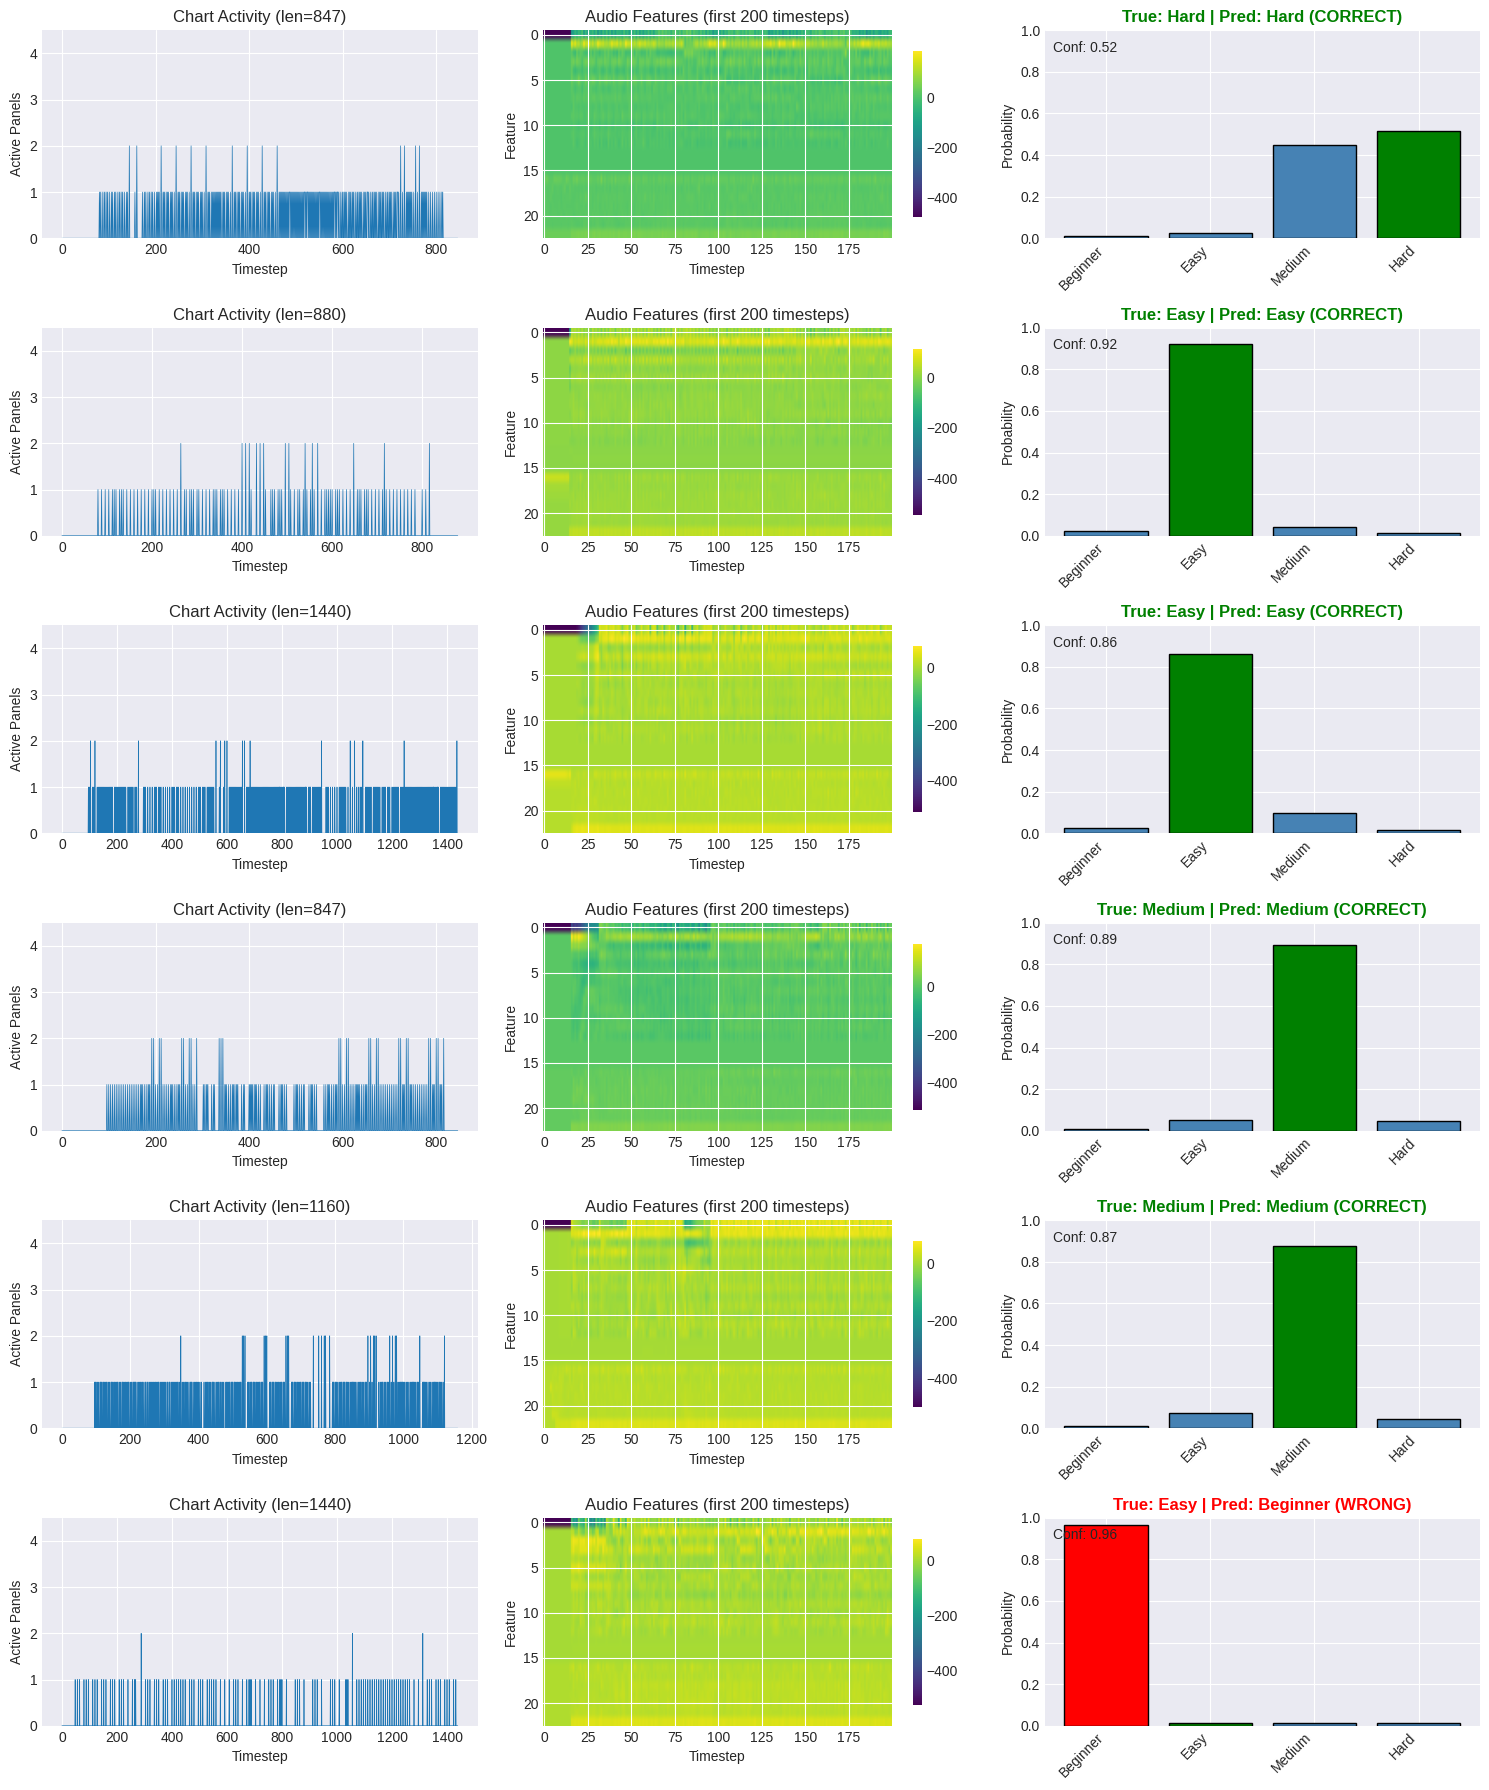

In [6]:
# Get a random batch and visualize
import random

def get_random_batch():
    """Get a random batch from the test loader."""
    batch_idx = random.randint(0, len(test_loader) - 1)
    for i, batch in enumerate(test_loader):
        if i == batch_idx:
            return batch
    return next(iter(test_loader))

# Run inference on random batch
batch = get_random_batch()

with torch.no_grad():
    audio = batch['audio'].to(device)
    chart = batch['chart'].to(device)
    mask = batch['mask'].to(device)
    chart_stats = batch.get('chart_stats', None)
    if chart_stats is not None:
        chart_stats = chart_stats.to(device)
    
    logits = model(audio, chart, mask, chart_stats=chart_stats)
    probabilities = F.softmax(logits, dim=1)
    predictions = model.predict_class_from_logits(logits)

print(f"Batch size: {batch['chart'].shape[0]}")
print(f"Sequence length: {batch['chart'].shape[1]}")
print(f"Audio features: {batch['audio'].shape[2]}")

visualize_batch(batch, predictions, probabilities, num_samples=6)

/home/ybx/code/stepmania-chart-generator/notebooks/../src/data/audio_features.py:165: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo_estimate = librosa.beat.tempo(
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?

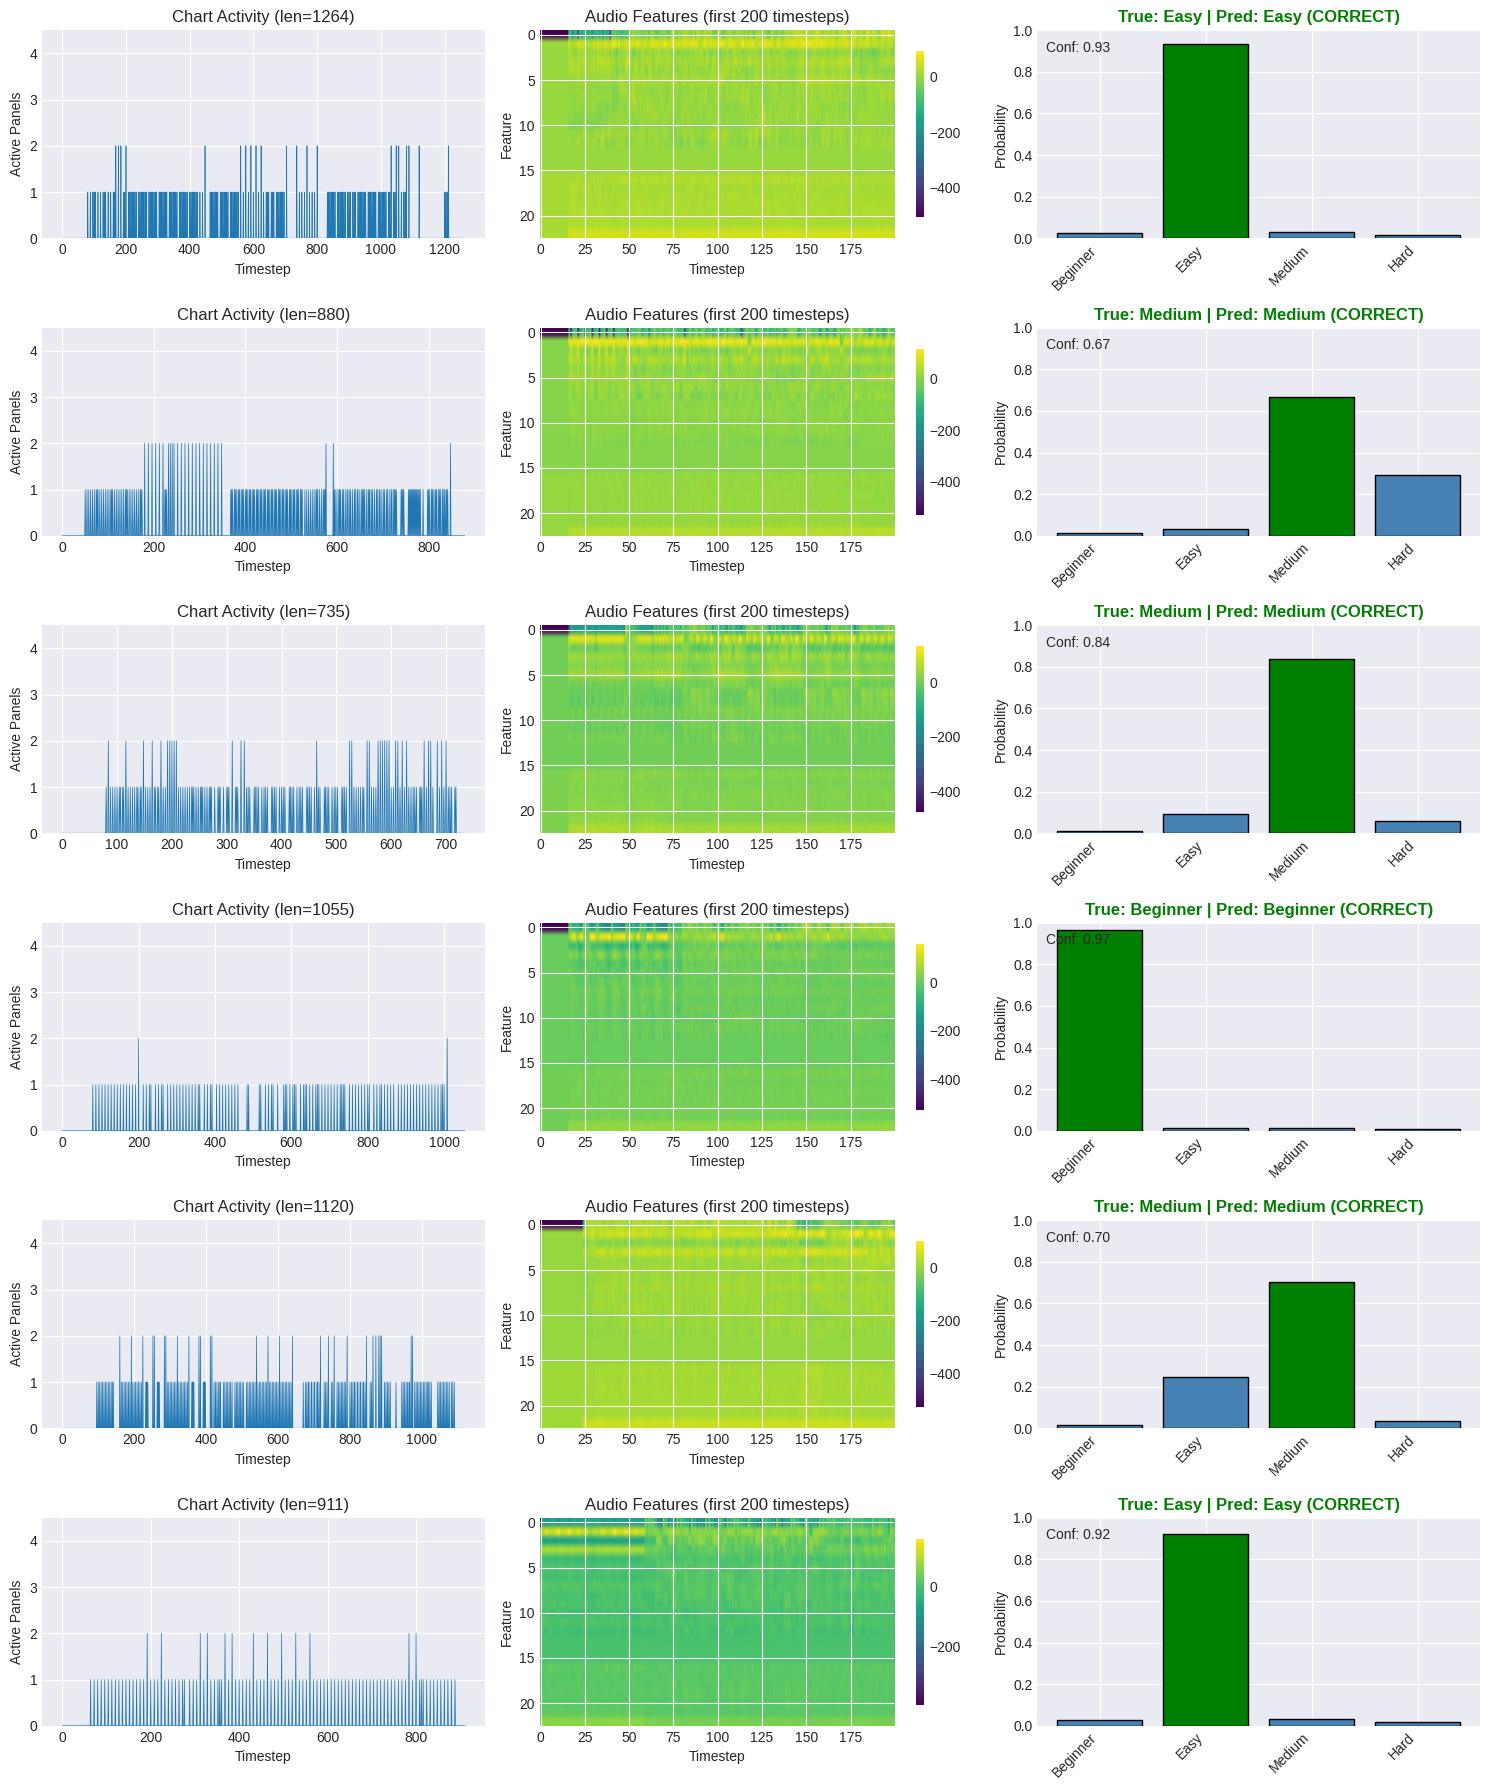

In [7]:
# Run again to see different samples
batch = get_random_batch()

with torch.no_grad():
    audio = batch['audio'].to(device)
    chart = batch['chart'].to(device)
    mask = batch['mask'].to(device)
    chart_stats = batch.get('chart_stats', None)
    if chart_stats is not None:
        chart_stats = chart_stats.to(device)
    
    logits = model(audio, chart, mask, chart_stats=chart_stats)
    probabilities = F.softmax(logits, dim=1)
    predictions = model.predict_class_from_logits(logits)

visualize_batch(batch, predictions, probabilities, num_samples=6)

## 5. Full Test Epoch Evaluation

Run evaluation on the entire test set and compute comprehensive metrics.

In [8]:
from torchmetrics.classification import (
    MulticlassAccuracy, 
    MulticlassConfusionMatrix,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score
)

def evaluate_test_set(model, test_loader, device):
    """
    Run full evaluation on test set.
    
    Returns:
        Dictionary with all metrics and sample-level results
    """
    model.eval()
    
    # Initialize metrics
    accuracy = MulticlassAccuracy(num_classes=NUM_CLASSES, average='micro').to(device)
    accuracy_per_class = MulticlassAccuracy(num_classes=NUM_CLASSES, average=None).to(device)
    confusion = MulticlassConfusionMatrix(num_classes=NUM_CLASSES).to(device)
    precision = MulticlassPrecision(num_classes=NUM_CLASSES, average=None).to(device)
    recall = MulticlassRecall(num_classes=NUM_CLASSES, average=None).to(device)
    f1 = MulticlassF1Score(num_classes=NUM_CLASSES, average=None).to(device)
    
    # Collect sample-level results
    all_predictions = []
    all_targets = []
    all_probabilities = []
    all_confidences = []
    all_losses = []
    
    criterion = torch.nn.CrossEntropyLoss(reduction='none')
    total_loss = 0.0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating test set"):
            audio = batch['audio'].to(device)
            chart = batch['chart'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['difficulty'].to(device)
            
            chart_stats = batch.get('chart_stats', None)
            if chart_stats is not None:
                chart_stats = chart_stats.to(device)
            
            # Forward pass
            logits = model(audio, chart, mask, chart_stats=chart_stats)
            
            # Compute loss
            losses = criterion(logits, targets)
            total_loss += losses.sum().item()
            
            # Get predictions and probabilities
            probs = F.softmax(logits, dim=1)
            preds = model.predict_class_from_logits(logits)
            confidences = probs.max(dim=1).values
            
            # Update metrics
            accuracy.update(preds, targets)
            accuracy_per_class.update(preds, targets)
            confusion.update(preds, targets)
            precision.update(preds, targets)
            recall.update(preds, targets)
            f1.update(preds, targets)
            
            # Store sample-level results
            all_predictions.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probabilities.extend(probs.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())
            all_losses.extend(losses.cpu().numpy())
    
    # Compute final metrics
    results = {
        'accuracy': accuracy.compute().item(),
        'accuracy_per_class': accuracy_per_class.compute().cpu().numpy(),
        'confusion_matrix': confusion.compute().cpu().numpy(),
        'precision': precision.compute().cpu().numpy(),
        'recall': recall.compute().cpu().numpy(),
        'f1': f1.compute().cpu().numpy(),
        'avg_loss': total_loss / len(test_loader.dataset),
        'predictions': np.array(all_predictions),
        'targets': np.array(all_targets),
        'probabilities': np.array(all_probabilities),
        'confidences': np.array(all_confidences),
        'losses': np.array(all_losses)
    }
    
    return results

# Run evaluation
results = evaluate_test_set(model, test_loader, device)

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Total samples: {len(results['predictions'])}")
print(f"Average loss: {results['avg_loss']:.4f}")
print(f"Overall accuracy: {results['accuracy']:.4f} ({results['accuracy']*100:.1f}%)")

Evaluating test set:   0%|                               | 0/10 [00:00<?, ?it/s]/home/ybx/code/stepmania-chart-generator/notebooks/../src/data/audio_features.py:165: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo_estimate = librosa.beat.tempo(
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Evaluating test set:  50%|███████████▌           | 5/10 [01:03<01:03, 12.68s/it][src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Evaluating test set:  80%|██████████████████▍    | 8/10 [01:40<00:25, 12.53s/it][src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:pr


TEST SET RESULTS
Total samples: 290
Average loss: 0.3257
Overall accuracy: 0.8828 (88.3%)


## 6. Confusion Matrix

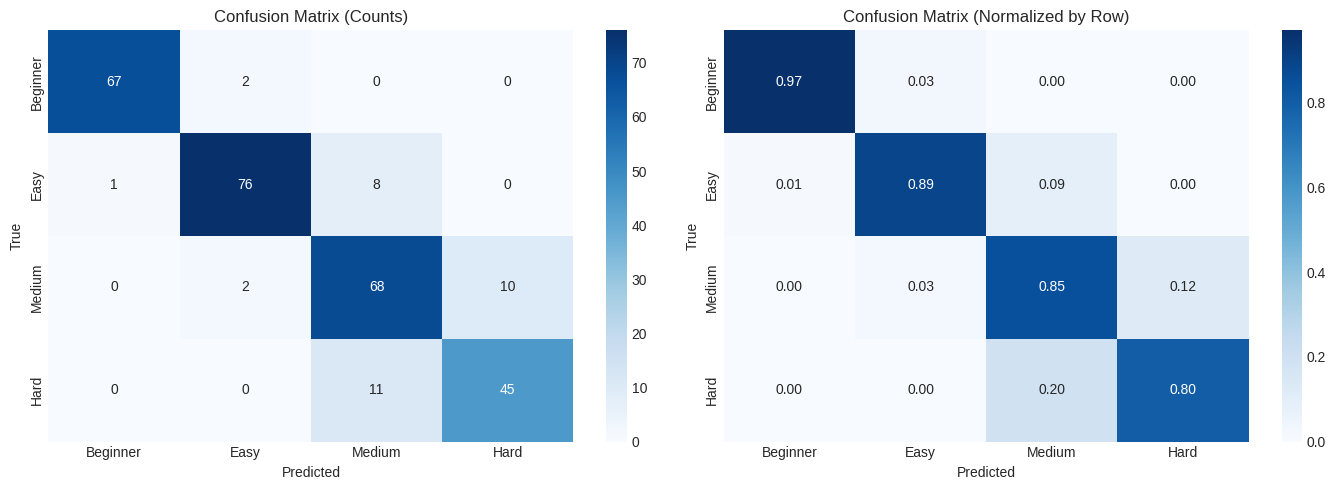

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw confusion matrix
ax = axes[0]
cm = results['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=DIFFICULTY_NAMES, yticklabels=DIFFICULTY_NAMES, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (Counts)')

# Normalized confusion matrix
ax = axes[1]
row_sums = cm.sum(axis=1, keepdims=True)
cm_normalized = np.divide(cm.astype('float'), row_sums, 
                          where=row_sums!=0, out=np.zeros_like(cm, dtype=float))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=DIFFICULTY_NAMES, yticklabels=DIFFICULTY_NAMES, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (Normalized by Row)')

plt.tight_layout()
plt.show()

## 7. Per-Class Metrics

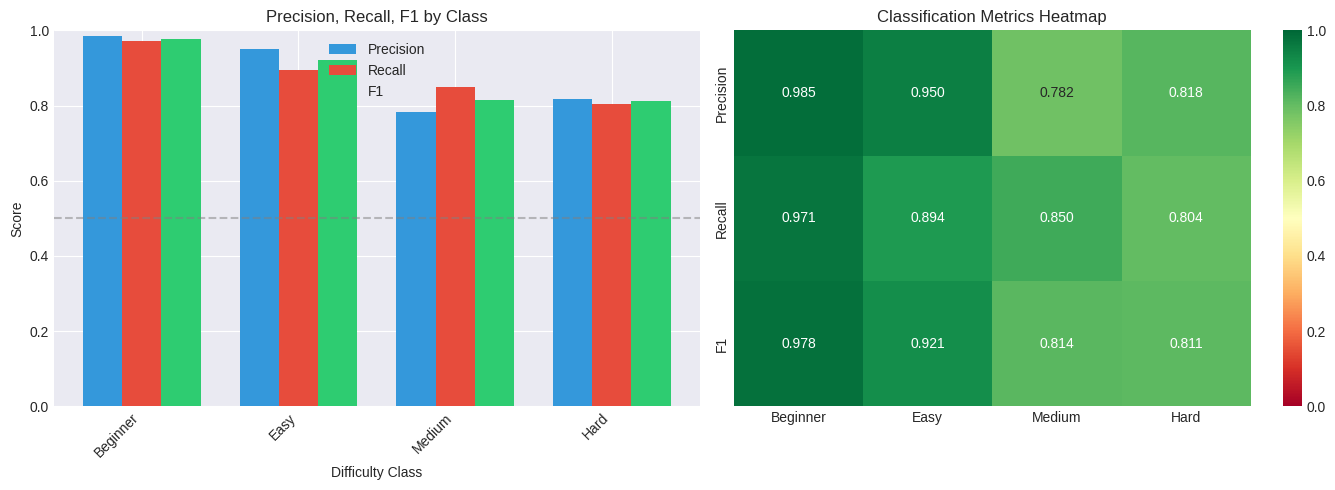


Per-Class Classification Metrics:
----------------------------------------------------------------------
       Class  Precision     Recall         F1   Accuracy    Support
----------------------------------------------------------------------
    Beginner      0.985      0.971      0.978      0.971         69
        Easy      0.950      0.894      0.921      0.894         85
      Medium      0.782      0.850      0.814      0.850         80
        Hard      0.818      0.804      0.811      0.804         56
----------------------------------------------------------------------
   Macro Avg      0.884      0.880      0.881          -        290
    Weighted      0.886      0.883      0.884          -        290


In [10]:
# Create metrics visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax = axes[0]
x = np.arange(NUM_CLASSES)
width = 0.25

bars1 = ax.bar(x - width, results['precision'], width, label='Precision', color='#3498db')
bars2 = ax.bar(x, results['recall'], width, label='Recall', color='#e74c3c')
bars3 = ax.bar(x + width, results['f1'], width, label='F1', color='#2ecc71')

ax.set_xlabel('Difficulty Class')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, F1 by Class')
ax.set_xticks(x)
ax.set_xticklabels(DIFFICULTY_NAMES, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.legend()
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Heatmap
ax = axes[1]
metrics_matrix = np.vstack([results['precision'], results['recall'], results['f1']])
sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=DIFFICULTY_NAMES, yticklabels=['Precision', 'Recall', 'F1'],
            ax=ax, vmin=0, vmax=1, center=0.5)
ax.set_title('Classification Metrics Heatmap')

plt.tight_layout()
plt.show()

# Print detailed table
print("\nPer-Class Classification Metrics:")
print("-" * 70)
print(f"{'Class':>12} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Accuracy':>10} {'Support':>10}")
print("-" * 70)

support = results['confusion_matrix'].sum(axis=1)
for i in range(NUM_CLASSES):
    print(f"{DIFFICULTY_NAMES[i]:>12} {results['precision'][i]:>10.3f} {results['recall'][i]:>10.3f} "
          f"{results['f1'][i]:>10.3f} {results['accuracy_per_class'][i]:>10.3f} {int(support[i]):>10}")
print("-" * 70)

# Macro and weighted averages
macro_prec = results['precision'].mean()
macro_rec = results['recall'].mean()
macro_f1 = results['f1'].mean()

total_support = support.sum()
weighted_prec = (results['precision'] * support).sum() / total_support
weighted_rec = (results['recall'] * support).sum() / total_support
weighted_f1 = (results['f1'] * support).sum() / total_support

print(f"{'Macro Avg':>12} {macro_prec:>10.3f} {macro_rec:>10.3f} {macro_f1:>10.3f} {'-':>10} {int(total_support):>10}")
print(f"{'Weighted':>12} {weighted_prec:>10.3f} {weighted_rec:>10.3f} {weighted_f1:>10.3f} {'-':>10} {int(total_support):>10}")

## 8. Error Analysis

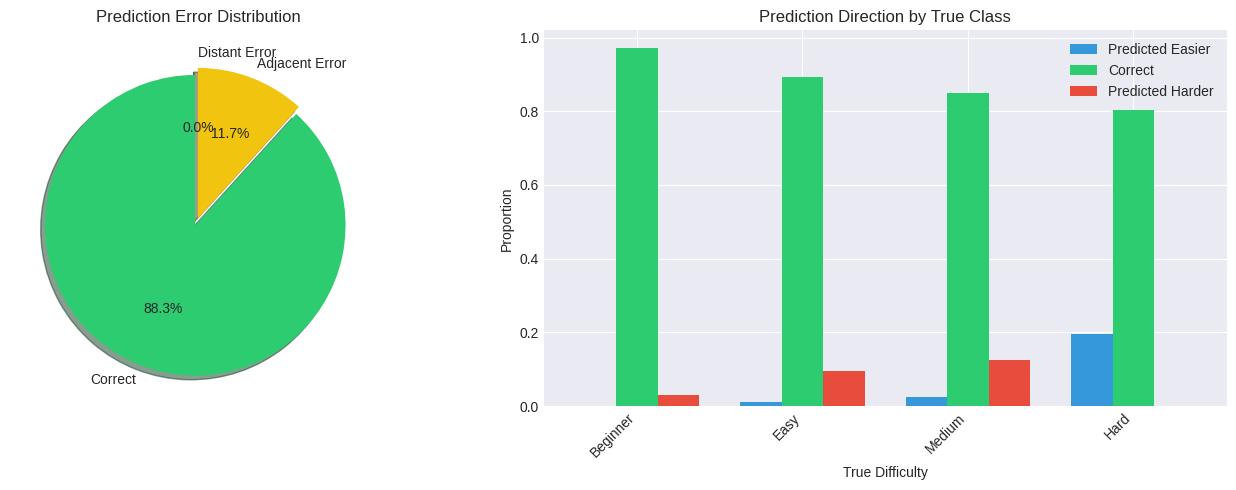


Error Analysis Summary:
  Total samples:     290
  Correct:           256 (88.3%)
  Adjacent errors:   34 (11.7%)
  Distant errors:    0 (0.0%)

  Mean Absolute Error: 0.117
  (Lower is better - 0 means perfect predictions)


In [11]:
# Analyze error patterns
predictions = results['predictions']
targets = results['targets']
cm = results['confusion_matrix']

correct = (predictions == targets).sum()
total = len(predictions)

# Categorize errors by distance
adjacent_errors = 0
distant_errors = 0

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i == j:
            continue
        distance = abs(i - j)
        if distance == 1:
            adjacent_errors += cm[i, j]
        else:
            distant_errors += cm[i, j]

# Calculate MAE
mae = np.abs(predictions - targets).mean()

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error type pie chart
ax = axes[0]
sizes = [correct, adjacent_errors, distant_errors]
labels = ['Correct', 'Adjacent Error', 'Distant Error']
colors = ['#2ecc71', '#f1c40f', '#e74c3c']
explode = (0.05, 0, 0)
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax.set_title('Prediction Error Distribution')

# Error direction by class
ax = axes[1]
error_flow = np.zeros((NUM_CLASSES, 3))  # [under-predict, correct, over-predict]
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if j < i:
            error_flow[i, 0] += cm[i, j]  # Under-predicted (easier)
        elif j == i:
            error_flow[i, 1] += cm[i, j]  # Correct
        else:
            error_flow[i, 2] += cm[i, j]  # Over-predicted (harder)

row_sums = error_flow.sum(axis=1, keepdims=True)
error_flow_norm = np.divide(error_flow, row_sums, where=row_sums!=0, 
                            out=np.zeros_like(error_flow))

x = np.arange(NUM_CLASSES)
width = 0.25
ax.bar(x - width, error_flow_norm[:, 0], width, label='Predicted Easier', color='#3498db')
ax.bar(x, error_flow_norm[:, 1], width, label='Correct', color='#2ecc71')
ax.bar(x + width, error_flow_norm[:, 2], width, label='Predicted Harder', color='#e74c3c')
ax.set_xlabel('True Difficulty')
ax.set_ylabel('Proportion')
ax.set_title('Prediction Direction by True Class')
ax.set_xticks(x)
ax.set_xticklabels(DIFFICULTY_NAMES, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Print summary
print("\nError Analysis Summary:")
print(f"  Total samples:     {total}")
print(f"  Correct:           {correct} ({100*correct/total:.1f}%)")
print(f"  Adjacent errors:   {adjacent_errors} ({100*adjacent_errors/total:.1f}%)")
print(f"  Distant errors:    {distant_errors} ({100*distant_errors/total:.1f}%)")
print(f"\n  Mean Absolute Error: {mae:.3f}")
print(f"  (Lower is better - 0 means perfect predictions)")

## 9. Confidence Analysis

/tmp/ipykernel_442569/4190043043.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(conf_by_class, labels=DIFFICULTY_NAMES, patch_artist=True)


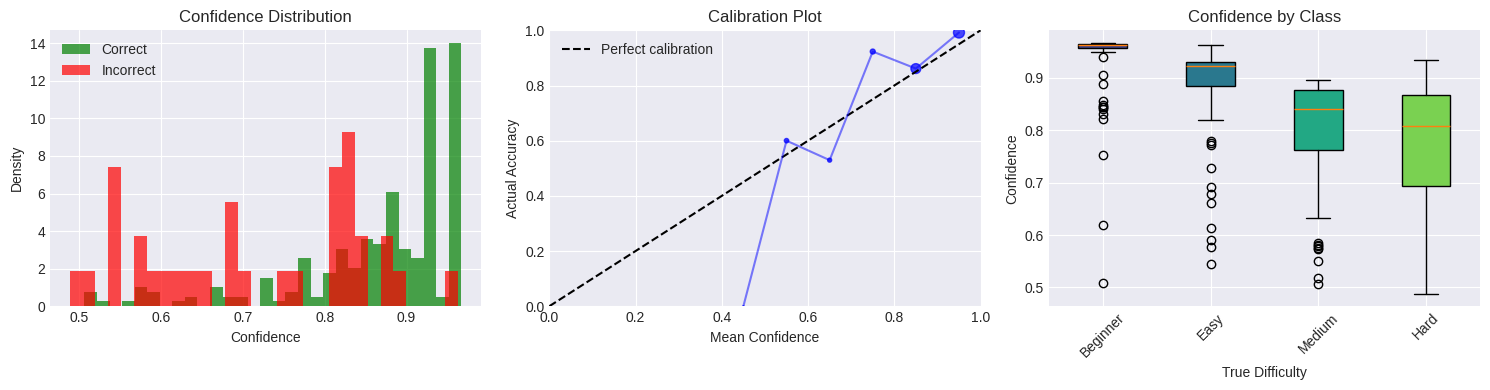


Confidence Statistics:
  Mean confidence (correct):   0.868
  Mean confidence (incorrect): 0.717
  Overall mean confidence:     0.850


In [12]:
confidences = results['confidences']
is_correct = (predictions == targets)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Confidence distribution
ax = axes[0]
ax.hist(confidences[is_correct], bins=30, alpha=0.7, label='Correct', color='green', density=True)
ax.hist(confidences[~is_correct], bins=30, alpha=0.7, label='Incorrect', color='red', density=True)
ax.set_xlabel('Confidence')
ax.set_ylabel('Density')
ax.set_title('Confidence Distribution')
ax.legend()

# Confidence vs accuracy (calibration)
ax = axes[1]
bins = np.linspace(0, 1, 11)
bin_indices = np.digitize(confidences, bins) - 1
bin_accuracies = []
bin_counts = []
bin_centers = []

for i in range(len(bins) - 1):
    mask = bin_indices == i
    if mask.sum() > 0:
        bin_accuracies.append(is_correct[mask].mean())
        bin_counts.append(mask.sum())
        bin_centers.append((bins[i] + bins[i+1]) / 2)

ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
ax.scatter(bin_centers, bin_accuracies, s=[c/2 for c in bin_counts], alpha=0.7, c='blue')
ax.plot(bin_centers, bin_accuracies, 'b-', alpha=0.5)
ax.set_xlabel('Mean Confidence')
ax.set_ylabel('Actual Accuracy')
ax.set_title('Calibration Plot')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()

# Confidence by class
ax = axes[2]
conf_by_class = [confidences[targets == i] for i in range(NUM_CLASSES)]
bp = ax.boxplot(conf_by_class, labels=DIFFICULTY_NAMES, patch_artist=True)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, NUM_CLASSES))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xlabel('True Difficulty')
ax.set_ylabel('Confidence')
ax.set_title('Confidence by Class')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary
print("\nConfidence Statistics:")
print(f"  Mean confidence (correct):   {confidences[is_correct].mean():.3f}")
print(f"  Mean confidence (incorrect): {confidences[~is_correct].mean():.3f}")
print(f"  Overall mean confidence:     {confidences.mean():.3f}")

## 10. Hardest and Easiest Samples

Identify samples where the model is most/least confident or has highest/lowest loss.

In [13]:
losses = results['losses']

# Get indices sorted by loss
hardest_indices = np.argsort(losses)[::-1][:20]  # Highest loss
easiest_indices = np.argsort(losses)[:20]  # Lowest loss

print("HARDEST SAMPLES (Highest Loss):")
print("-" * 70)
print(f"{'Idx':>6} {'True':>10} {'Pred':>10} {'Conf':>8} {'Loss':>10} {'Correct':>8}")
print("-" * 70)
for idx in hardest_indices[:10]:
    true_label = DIFFICULTY_NAMES[targets[idx]]
    pred_label = DIFFICULTY_NAMES[predictions[idx]]
    conf = confidences[idx]
    loss = losses[idx]
    correct = "Yes" if is_correct[idx] else "No"
    print(f"{idx:>6} {true_label:>10} {pred_label:>10} {conf:>8.3f} {loss:>10.4f} {correct:>8}")

print("\n\nEASIEST SAMPLES (Lowest Loss):")
print("-" * 70)
print(f"{'Idx':>6} {'True':>10} {'Pred':>10} {'Conf':>8} {'Loss':>10} {'Correct':>8}")
print("-" * 70)
for idx in easiest_indices[:10]:
    true_label = DIFFICULTY_NAMES[targets[idx]]
    pred_label = DIFFICULTY_NAMES[predictions[idx]]
    conf = confidences[idx]
    loss = losses[idx]
    correct = "Yes" if is_correct[idx] else "No"
    print(f"{idx:>6} {true_label:>10} {pred_label:>10} {conf:>8.3f} {loss:>10.4f} {correct:>8}")

HARDEST SAMPLES (Highest Loss):
----------------------------------------------------------------------
   Idx       True       Pred     Conf       Loss  Correct
----------------------------------------------------------------------
     5       Easy   Beginner    0.963     4.2194       No
   152       Hard     Medium    0.826     3.2622       No
   123       Easy     Medium    0.879     2.7746       No
   195       Hard     Medium    0.825     2.4021       No
   260     Medium       Hard    0.886     2.3624       No
    77     Medium       Hard    0.871     2.2211       No
    14   Beginner       Easy    0.840     2.1768       No
   157       Easy     Medium    0.826     2.0817       No
    40       Hard     Medium    0.823     2.0561       No
    99       Easy     Medium    0.820     2.0465       No


EASIEST SAMPLES (Lowest Loss):
----------------------------------------------------------------------
   Idx       True       Pred     Conf       Loss  Correct
--------------------------

/tmp/ipykernel_442569/3141561086.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(loss_by_class, labels=DIFFICULTY_NAMES, patch_artist=True)


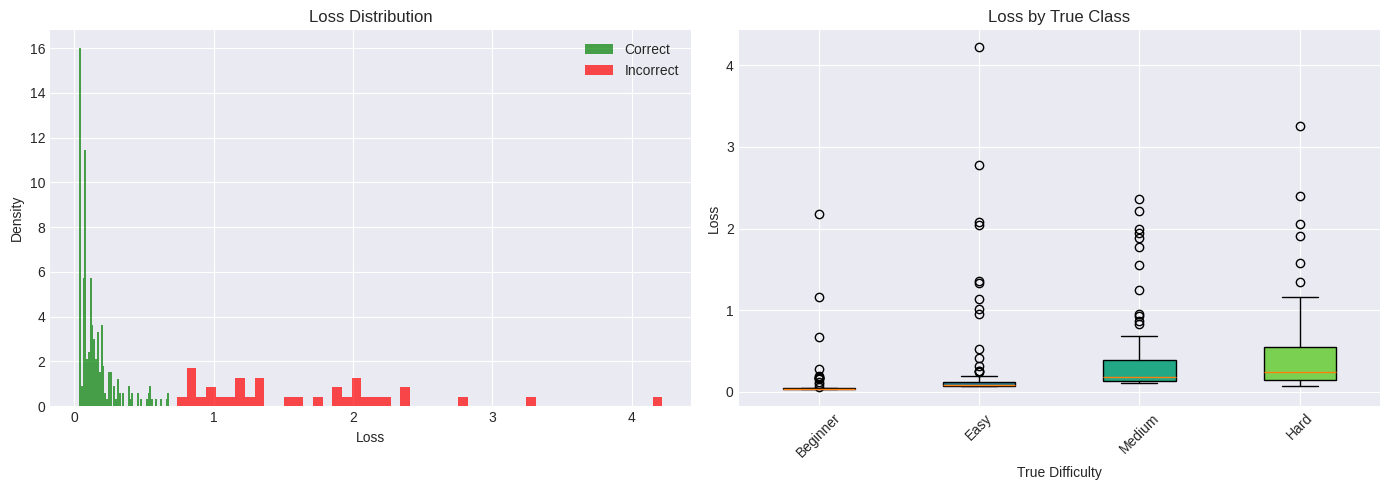

In [14]:
# Visualize loss distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss distribution
ax = axes[0]
ax.hist(losses[is_correct], bins=50, alpha=0.7, label='Correct', color='green', density=True)
ax.hist(losses[~is_correct], bins=50, alpha=0.7, label='Incorrect', color='red', density=True)
ax.set_xlabel('Loss')
ax.set_ylabel('Density')
ax.set_title('Loss Distribution')
ax.legend()

# Loss by true class
ax = axes[1]
loss_by_class = [losses[targets == i] for i in range(NUM_CLASSES)]
bp = ax.boxplot(loss_by_class, labels=DIFFICULTY_NAMES, patch_artist=True)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, NUM_CLASSES))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xlabel('True Difficulty')
ax.set_ylabel('Loss')
ax.set_title('Loss by True Class')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 11. Probability Distribution Analysis

Analyze the full probability distributions for correct and incorrect predictions.

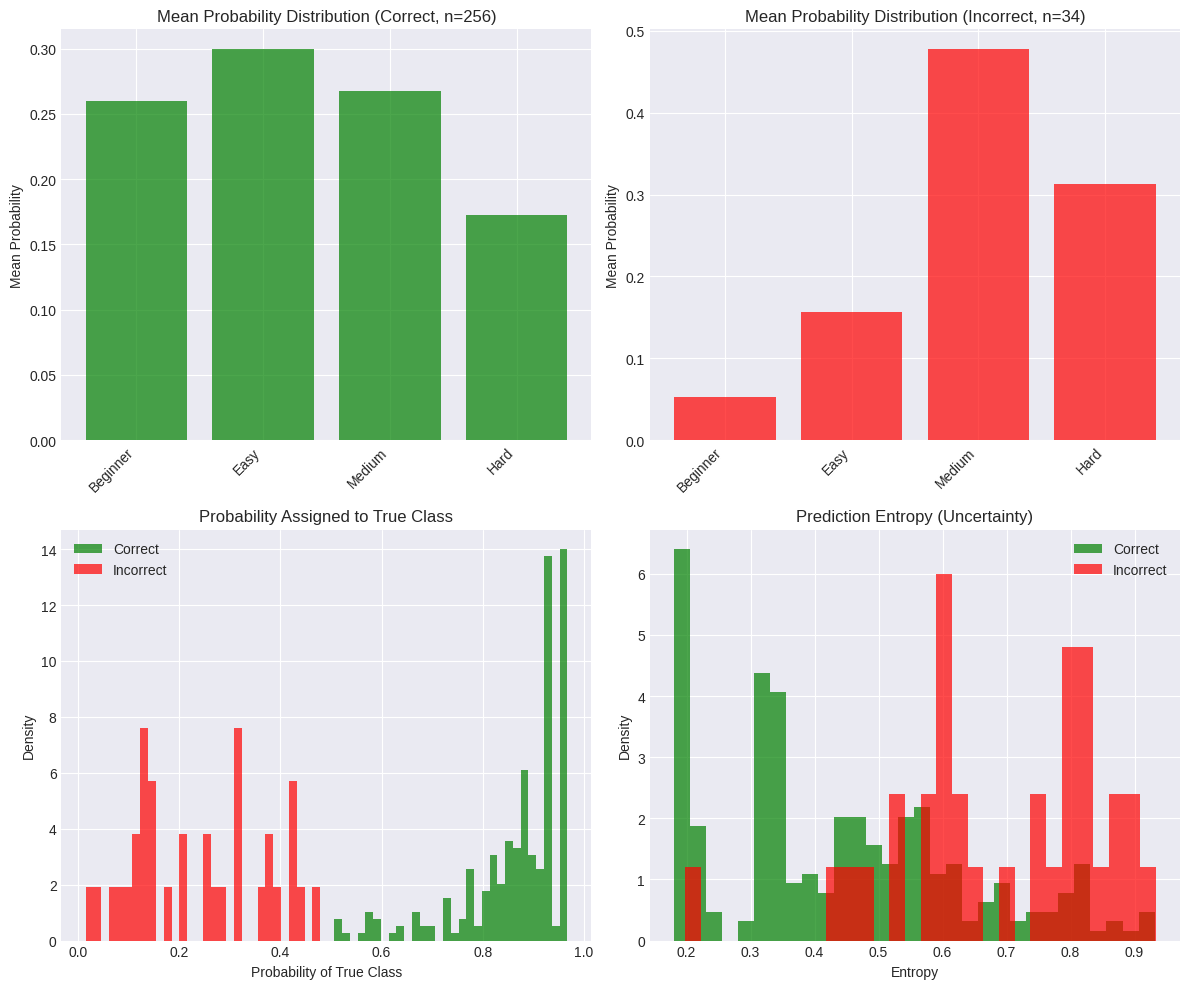


Probability Analysis:
  Mean prob of true class (correct):   0.868
  Mean prob of true class (incorrect): 0.238
  Mean entropy (correct):   0.440
  Mean entropy (incorrect): 0.690


In [15]:
probabilities = results['probabilities']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Average probability distribution for correct predictions
ax = axes[0, 0]
correct_probs = probabilities[is_correct]
mean_correct_probs = correct_probs.mean(axis=0)
ax.bar(range(NUM_CLASSES), mean_correct_probs, color='green', alpha=0.7)
ax.set_xticks(range(NUM_CLASSES))
ax.set_xticklabels(DIFFICULTY_NAMES, rotation=45, ha='right')
ax.set_ylabel('Mean Probability')
ax.set_title(f'Mean Probability Distribution (Correct, n={is_correct.sum()})')

# Average probability distribution for incorrect predictions
ax = axes[0, 1]
incorrect_probs = probabilities[~is_correct]
if len(incorrect_probs) > 0:
    mean_incorrect_probs = incorrect_probs.mean(axis=0)
    ax.bar(range(NUM_CLASSES), mean_incorrect_probs, color='red', alpha=0.7)
ax.set_xticks(range(NUM_CLASSES))
ax.set_xticklabels(DIFFICULTY_NAMES, rotation=45, ha='right')
ax.set_ylabel('Mean Probability')
ax.set_title(f'Mean Probability Distribution (Incorrect, n={(~is_correct).sum()})')

# Probability assigned to true class
ax = axes[1, 0]
true_class_probs = probabilities[np.arange(len(targets)), targets]
ax.hist(true_class_probs[is_correct], bins=30, alpha=0.7, label='Correct', color='green', density=True)
ax.hist(true_class_probs[~is_correct], bins=30, alpha=0.7, label='Incorrect', color='red', density=True)
ax.set_xlabel('Probability of True Class')
ax.set_ylabel('Density')
ax.set_title('Probability Assigned to True Class')
ax.legend()

# Entropy of predictions (uncertainty)
ax = axes[1, 1]
entropy = -np.sum(probabilities * np.log(probabilities + 1e-10), axis=1)
ax.hist(entropy[is_correct], bins=30, alpha=0.7, label='Correct', color='green', density=True)
ax.hist(entropy[~is_correct], bins=30, alpha=0.7, label='Incorrect', color='red', density=True)
ax.set_xlabel('Entropy')
ax.set_ylabel('Density')
ax.set_title('Prediction Entropy (Uncertainty)')
ax.legend()

plt.tight_layout()
plt.show()

print("\nProbability Analysis:")
print(f"  Mean prob of true class (correct):   {true_class_probs[is_correct].mean():.3f}")
print(f"  Mean prob of true class (incorrect): {true_class_probs[~is_correct].mean():.3f}")
print(f"  Mean entropy (correct):   {entropy[is_correct].mean():.3f}")
print(f"  Mean entropy (incorrect): {entropy[~is_correct].mean():.3f}")

## 12. Summary Report

In [17]:
correct = (predictions == targets).sum()
print("="*70)
print("                        TEST SET EVALUATION SUMMARY")
print("="*70)
print(f"\nModel: {CHECKPOINT_DIR.name}")
print(f"Checkpoint: {CHECKPOINT_NAME}")
print(f"Epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"\n" + "-"*70)
print("OVERALL METRICS")
print("-"*70)
print(f"  Test samples:        {len(predictions)}")
print(f"  Average loss:        {results['avg_loss']:.4f}")
print(f"  Accuracy:            {results['accuracy']:.4f} ({results['accuracy']*100:.1f}%)")
print(f"  Macro F1:            {macro_f1:.4f}")
print(f"  Weighted F1:         {weighted_f1:.4f}")
print(f"  Mean Absolute Error: {mae:.4f}")

print(f"\n" + "-"*70)
print("PER-CLASS PERFORMANCE")
print("-"*70)
for i in range(NUM_CLASSES):
    print(f"  {DIFFICULTY_NAMES[i]:>10}: P={results['precision'][i]:.3f} R={results['recall'][i]:.3f} F1={results['f1'][i]:.3f}")

print(f"\n" + "-"*70)
print("ERROR ANALYSIS")
print("-"*70)
print(f"  Correct predictions: {correct} ({100*correct/total:.1f}%)")
print(f"  Adjacent errors:     {adjacent_errors} ({100*adjacent_errors/total:.1f}%)")
print(f"  Distant errors:      {distant_errors} ({100*distant_errors/total:.1f}%)")

# Identify problem areas
print(f"\n" + "-"*70)
print("PROBLEM AREAS")
print("-"*70)
problem_classes = np.where(results['f1'] < 0.7)[0]
if len(problem_classes) > 0:
    for c in problem_classes:
        print(f"  {DIFFICULTY_NAMES[c]}: F1={results['f1'][c]:.3f}")
        if results['recall'][c] < results['precision'][c]:
            print(f"    -> Low recall: model misses many {DIFFICULTY_NAMES[c]} samples")
        else:
            print(f"    -> Low precision: model over-predicts {DIFFICULTY_NAMES[c]}")
else:
    print("  No major problem areas (all F1 >= 0.7)")

print("\n" + "="*70)

                        TEST SET EVALUATION SUMMARY

Model: classifier_01_03_21-38
Checkpoint: best_val_loss.pt
Epoch: 15

----------------------------------------------------------------------
OVERALL METRICS
----------------------------------------------------------------------
  Test samples:        290
  Average loss:        0.3257
  Accuracy:            0.8828 (88.3%)
  Macro F1:            0.8811
  Weighted F1:         0.8840
  Mean Absolute Error: 0.1172

----------------------------------------------------------------------
PER-CLASS PERFORMANCE
----------------------------------------------------------------------
    Beginner: P=0.985 R=0.971 F1=0.978
        Easy: P=0.950 R=0.894 F1=0.921
      Medium: P=0.782 R=0.850 F1=0.814
        Hard: P=0.818 R=0.804 F1=0.811

----------------------------------------------------------------------
ERROR ANALYSIS
----------------------------------------------------------------------
  Correct predictions: 256 (88.3%)
  Adjacent errors:  